# Plot cell fractions by condition, population, cell cycle

## Import statements

In [79]:
import os,sys
import datetime

In [80]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
Memory usage: current 0.01 GB, difference -0.18 GB


In [81]:
## This cell is run once to download my custom functions and import statements from github
#
#!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
#    
## github doesn't seem to have an option to download a specific version of the repo from the history.
## So I download my utility functions and save the download time by appending it to the directory name.
## These utility functions to be shared together with the notebook.
#
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#newname = "utility_functions_%s"%toappend
#print(newname)
#
#
## rename the py file with utility functions
#os.rename("utility_functions",newname)

In [82]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_210525_14h42/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

## More functions

In [83]:
def get_cell_counts(
    label1,
    label2,
    meta):
    
    twocols = meta[[label1,label2]]
    if twocols.shape[0]!=(twocols.dropna()).shape[0]:
        print("NaN values in meta dataframe provided")
        return
    cs = meta.groupby([label1,label2]).count().iloc[:,0]
    cframe = pd.DataFrame(columns=cs.index.levels[0]
                          ,index = cs.index.levels[1])
    for i in cs.index.levels[0]:
        cframe[i] = cs[i]
    cframe.fillna(0,inplace=True)
    return cframe

rz.get_cell_counts = get_cell_counts
del get_cell_counts

In [84]:
def plot_stacked_bars(
    cframe,
    w = 50,
    h = 5,
    color_dict=None,
    title='',
    save=False,
    ylabel='',
    xlabel='',
    comment='',
    rotation=90,
    ncol=2,
    barwidth=0.8,
    wrs=[1,1],
    rect = [0.05,0,1,1],
    colrenamer = {},
    joinbars = True,
    baralpha = 1,
    polyalpha = 0.5,
    
    ):
    """
    ncol - nr columns for legend
    wrs - ratio of bar width (all bars) vs legend width
    
    """

    a,fig,gs=rz.startfig(w,h,columns=2,wrs=wrs)
    x = np.arange(cframe.shape[1])
    bottom = np.repeat(0,cframe.shape[1])
    #hack to reverse the order in the legend
    brs = []
    lbls = cframe.index
    
    # for plotting bar-connecting lines
    gaps = [[lx1,lx2] for lx1,lx2 in zip(x[:-1]+barwidth/2.,x[1:]-barwidth/2.)]
    
    if color_dict is None:
        color_dict = {key:None for key in cframe.index}
        
    for ctype in cframe.index:
        h = cframe.loc[ctype]
        br = a.bar(x,h,barwidth, bottom,label=ctype,color=color_dict[ctype],alpha=baralpha)
        brs.append(br)
        ybottoms=[[b1,b2] for b1, b2 in zip(bottom[:-1],bottom[1:])]
        bottom=bottom+h
        ytops = [[t1,t2] for t1, t2 in zip(bottom[:-1],bottom[1:])]
        
        if joinbars:
            for linex,by,ty in zip(gaps,ybottoms,ytops):
                xy = np.array([
                                [linex[0],by[0]],
                                [linex[0],ty[0]],
                                [linex[1],ty[1]],
                                [linex[1],by[1]]
                              ])
                
                #a.plot(linex,liney,lw=1,color='0.5')
                polygone = mpl.patches.Polygon(xy, closed=True,lw=0,facecolor=color_dict[ctype],alpha=polyalpha)
                a.add_patch(polygone)
        
    a.legend(brs[::-1],lbls[::-1],ncol=ncol,bbox_to_anchor=(1,1),fontsize=5)
    a.set_xticks(x)
    xticklabels = [colrenamer[i] if i in colrenamer else i for i in cframe.columns]   
    a.set_xticklabels(xticklabels,rotation=rotation);
    a.set_title(title)
    rz.showspines(a,left=True,bottom=True)
    a.set_ylabel(ylabel)
    a.set_xlabel(xlabel)

    gs.tight_layout(fig,rect=rect)
    if save==True:
        plt.savefig('postannotoutputs/stacked_bars_%s.pdf'%comment)
    plt.show()

## Load data

In [85]:
adata = sc.read_h5ad('backups/mito_total_counts_filt_raw_32415x36601_210622_20h17.h5ad')

In [86]:
# load obs with classifier results
adata.obs = rz.load_df('backups/obs_info_32415x18_211010_11h51.npz')

In [87]:
# normalize
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Load color dictionary used in SPRING explorer

In [88]:
path1 = "/Users/rapolaszilionis/Google Drive/DG/tmp_for_S3/20210616_RZ_macrophage_fastq_and_counts/quick_analysis_spring_plot/SPRING_dev-master/data/"
project_dir = path1+'/mamito/'
plot_name = 'all_above_900_UMAP_no_cc_2000/'

In [89]:
# load current color dictionary
cg0 = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')

# color dictionary
cdd = {key:value['label_colors'] for key,value in cg0.items()}

In [90]:
cdd['phase']

{'G0': '#008080', 'G1S': '#FFAE00', 'G2M': '#FF0000'}

## Save in a dedicated output folder

In [91]:
!mkdir -p postannotoutputs

## Get fractions of cells per condition

### Fraction population

In [92]:
cmask = np.repeat(True,adata.shape[0])
print(cmask.sum(),len(cmask))
col1 = 'condition'
col2 = 'population'
cell_counts = rz.get_cell_counts(col1,col2,adata.obs[cmask])

32415 32415


In [93]:
# Order as to have the most abundant cell types first (using the first column)
order = cell_counts.iloc[:,0].sort_values(ascending=False).index
cell_counts = cell_counts.loc[order]

In [94]:
cell_counts

condition,Control,KIPyV VLPs,MCPyV VLPs
population,,,
MA,3662,1154,1672
RS,3064,176,163
PA,2191,369,407
SS,692,1148,1457
Dead,164,693,544
AII,115,2204,3126
AI,113,4717,3188
HA,57,380,663
IR,8,20,268


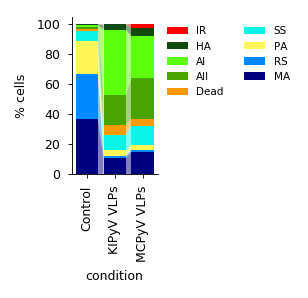

In [95]:
cell_fracs = cell_counts/cell_counts.sum()*100.
plot_stacked_bars(cell_fracs,
                  color_dict=cdd[col2],
                  xlabel='condition',ylabel='% cells',
                  w=6,
                  wrs=[5,1],
                  barwidth=0.8,
                  save=True,
                  comment='cond_by_pop',
                  polyalpha=0.5,
                  joinbars = True)

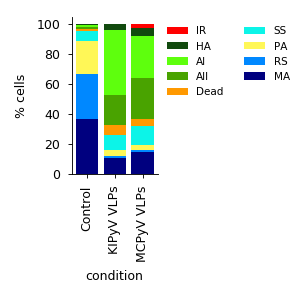

In [96]:
cell_fracs = cell_counts/cell_counts.sum()*100.
plot_stacked_bars(cell_fracs,
                  color_dict=cdd[col2],
                  xlabel='condition',ylabel='% cells',
                  w=6,
                  wrs=[5,1],
                  barwidth=0.8,
                  save=True,
                  comment='cond_by_pop_no_join',
                  polyalpha=0.5,
                  joinbars = False)

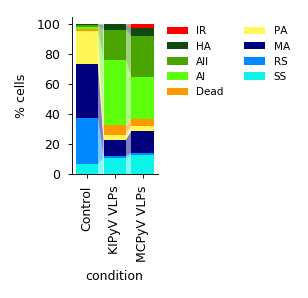

In [97]:
# alternative pre-defined order

custorder = ['SS','RS','MA','PA','Dead','AI','AII','HA','IR']
cell_counts = cell_counts.loc[custorder]

cell_fracs = cell_counts/cell_counts.sum()*100.
plot_stacked_bars(cell_fracs,
                  color_dict=cdd[col2],
                  xlabel='condition',ylabel='% cells',
                  w=6,
                  wrs=[5,1],
                  barwidth=0.8,
                  save=True,
                  comment='cond_by_pop_custorder',
                  polyalpha=0.5,
                  joinbars = True)

In [98]:
!open postannotoutputs/

### Fraction cycling cells

In [99]:
cmask = np.repeat(True,adata.shape[0])
print(cmask.sum(),len(cmask))
col1 = 'condition'
col2 = 'phase'
cell_counts = rz.get_cell_counts(col1,col2,adata.obs[cmask])

32415 32415


In [100]:
# Order as to have the most abundant cell groups first

order = cell_counts.iloc[:,0].sort_values(ascending=False).index
cell_counts = cell_counts.loc[order]

In [101]:
cell_counts

condition,Control,KIPyV VLPs,MCPyV VLPs
phase,,,
G0,4702,4532,6035
G2M,2706,2805,2564
G1S,2658,3524,2889


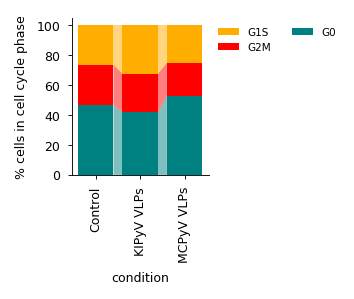

In [102]:
cell_fracs = cell_counts/cell_counts.sum()*100.
plot_stacked_bars(cell_fracs,
                  color_dict=cdd[col2],
                  xlabel='condition',ylabel='% cells in cell cycle phase',
                  w=7,
                  wrs=[5,1],
                  barwidth=0.8,
                  save=True,
                  comment='cond_by_phase',
                  polyalpha=0.5,
                  joinbars = True)

## Get fractions of cells per population

### Fraction condition

In [103]:
cmask = np.repeat(True,adata.shape[0])
print(cmask.sum(),len(cmask))
col1 = 'population'
col2 = 'condition'
cell_counts = rz.get_cell_counts(col1,col2,adata.obs[cmask])

32415 32415


In [104]:
# Order as to have the most abundant cell groups first
order = cell_counts.iloc[:,0].sort_values(ascending=False).index
cell_counts = cell_counts.loc[order]

In [105]:
cells_per_10k = cell_counts.T.copy()
cells_per_10k = cells_per_10k/cells_per_10k.sum()*10000.
cells_per_10k = cells_per_10k.T
cells_per_10k

population,AI,AII,Dead,HA,IR,MA,PA,RS,SS
condition,,,,,,,,,
KIPyV VLPs,4343.062333,2029.279072,638.062793,349.875702,18.414511,1062.517264,339.747721,162.047694,1056.992910
MCPyV VLPs,2775.069638,2721.100279,473.537604,577.123955,233.286908,1455.431755,354.282730,141.887187,1268.279944
Control,112.259090,114.245977,162.924697,56.626267,7.947546,3637.989271,2176.634214,3043.910193,687.462746


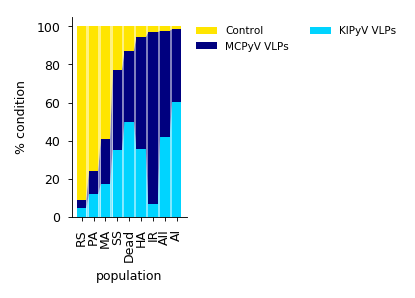

In [106]:
cell_fracs = cells_per_10k/cells_per_10k.sum()*100.

# order by decreasing fraction of condition 1 (reference)
order = cell_fracs.loc["Control",:].sort_values(ascending=False).index
cell_fracs = cell_fracs[order]


plot_stacked_bars(cell_fracs,
                  color_dict=cdd[col2],
                  xlabel='population',ylabel='% condition',
                  w=8,
                  wrs=[5,1],
                  barwidth=0.8,
                  save=True,
                  comment='pop_by_cond',
                  polyalpha=0.5,
                  joinbars = True)

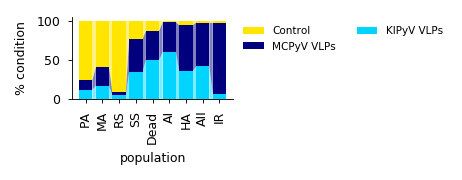

In [107]:
# same as above but custom order to match clustering results by gene expression
customorder = ['IR', 'AII', 'HA', 'AI', 'Dead', 'SS', 'RS', 'MA', 'PA']

plot_stacked_bars(cell_fracs[customorder[::-1]],
                  color_dict=cdd[col2],
                  xlabel='population',ylabel='% condition',
                  h=3,
                  w=9,
                  wrs=[5,1],
                  barwidth=0.8,
                  save=True,
                  comment='pop_by_cond_cust_order',
                  polyalpha=0.5,
                  joinbars = True)

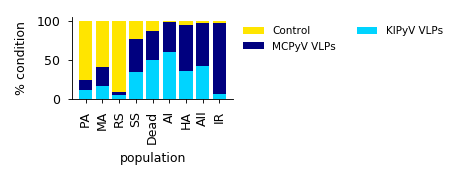

In [108]:
# same as above but custom order to match clustering results by gene expression
customorder = ['IR', 'AII', 'HA', 'AI', 'Dead', 'SS', 'RS', 'MA', 'PA']

plot_stacked_bars(cell_fracs[customorder[::-1]],
                  color_dict=cdd[col2],
                  xlabel='population',ylabel='% condition',
                  h=3,
                  w=9,
                  wrs=[5,1],
                  barwidth=0.8,
                  save=True,
                  comment='pop_by_cond_cust_order_no_join',
                  polyalpha=0.5,
                  joinbars = False)

### Fraction cycling

In [109]:
cmask = np.repeat(True,adata.shape[0])
print(cmask.sum(),len(cmask))
col1 = 'population'
col2 = 'phase'
cell_counts = rz.get_cell_counts(col1,col2,adata.obs[cmask])

32415 32415


In [110]:
# Order as to have the most abundant cell groups first
order = cell_counts.iloc[:,0].sort_values(ascending=False).index
cell_counts = cell_counts.loc[order]

In [111]:
cell_counts

population,AI,AII,Dead,HA,IR,MA,PA,RS,SS
phase,,,,,,,,,
G0,3244,3249,550,674,163,2583,1284,2046,1476
G1S,2619,1202,459,229,64,1934,852,699,1013
G2M,2155,994,392,197,69,1971,831,658,808


In [112]:
cells_per_10k = cell_counts.T.copy()
cells_per_10k = cells_per_10k/cells_per_10k.sum()*10000.
cells_per_10k = cells_per_10k.T
cells_per_10k

population,AI,AII,Dead,HA,IR,MA,PA,RS,SS
phase,,,,,,,,,
G0,2124.566114,2127.840723,360.206955,441.417251,106.752243,1691.662846,840.919510,1339.969874,966.664484
G1S,2887.223018,1325.101973,506.008158,252.452872,70.554514,2132.069232,939.256973,770.587587,1116.745673
G2M,2668.730650,1230.959752,485.448916,243.962848,85.448916,2440.866873,1029.102167,814.860681,1000.619195


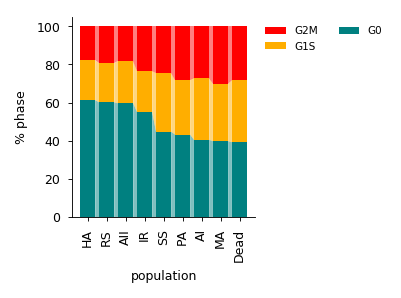

In [113]:
cell_fracs = cell_counts/cell_counts.sum()*100.

# order by decreasing fraction of condition 1 (reference)
order = cell_fracs.loc["G0",:].sort_values(ascending=False).index
cell_fracs = cell_fracs[order]

plot_stacked_bars(cell_fracs,
                  color_dict=cdd[col2],
                  xlabel='population',ylabel='% phase',
                  w=8,
                  wrs=[5,1],
                  barwidth=0.8,
                  save=True,
                  comment='pop_by_phase',
                  polyalpha=0.5,
                  joinbars = True)

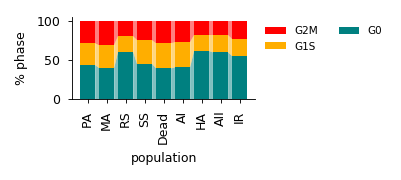

In [114]:
# custom order

# same as above but custom order to match clustering results by gene expression
customorder = ['IR', 'AII', 'HA', 'AI', 'Dead', 'SS', 'RS', 'MA', 'PA']

plot_stacked_bars(cell_fracs[customorder[::-1]],
                  color_dict=cdd[col2],
                  xlabel='population',ylabel='% phase',
                  h=3,
                  w=8,
                  wrs=[5,1],
                  barwidth=0.8,
                  save=True,
                  comment='pop_by_phase_cust_order',
                  polyalpha=0.5,
                  joinbars = True)

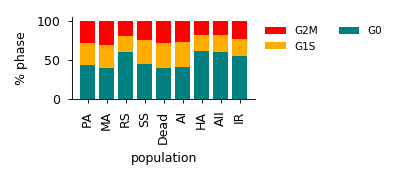

In [115]:
# custom order

# same as above but custom order to match clustering results by gene expression
customorder = ['IR', 'AII', 'HA', 'AI', 'Dead', 'SS', 'RS', 'MA', 'PA']

plot_stacked_bars(cell_fracs[customorder[::-1]],
                  color_dict=cdd[col2],
                  xlabel='population',ylabel='% phase',
                  h=3,
                  w=8,
                  wrs=[5,1],
                  barwidth=0.8,
                  save=True,
                  comment='pop_by_phase_cust_order_no_join',
                  polyalpha=0.5,
                  joinbars = False)

In [117]:
!open postannotoutputs/

## Correlation of cells fractions

In [19]:
cell_fracs

condition,Control,KIPyV VLPs,MCPyV VLPs
population,,,
MA,36.379893,10.625173,14.554318
RS,30.439102,1.620477,1.418872
PA,21.766342,3.397477,3.542827
SS,6.874627,10.569929,12.682799
Dead,1.629247,6.380628,4.735376
AII,1.142460,20.292791,27.211003
AI,1.122591,43.430623,27.750696
HA,0.566263,3.498757,5.771240
IR,0.079475,0.184145,2.332869


In [22]:
combs = [i for i in itertools.combinations(cell_fracs.columns,2)]
combs

[('Control', 'KIPyV VLPs'),
 ('Control', 'MCPyV VLPs'),
 ('KIPyV VLPs', 'MCPyV VLPs')]

### Linear percentages

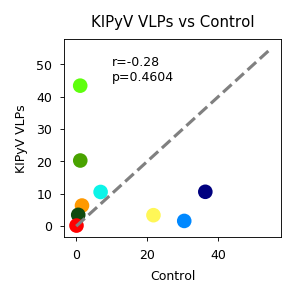

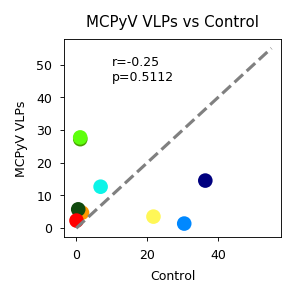

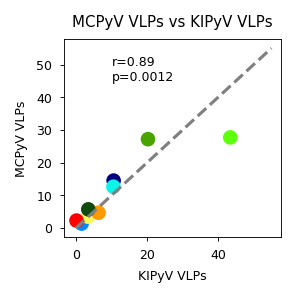

In [48]:
color = [cdd['population'][i] for i in cell_fracs.index]
for comb in combs:
    xlab = comb[0]
    ylab = comb[1]
    
    x = cell_fracs[xlab]
    y = cell_fracs[ylab]
    
    a,fig,gs = rz.startfig(5,5)
    a.plot((0,55),(0,55),'--',color='0.5')
    a.scatter(x,y,color=color)
    a.set_xlabel(xlab)
    a.set_ylabel(ylab)
    
    title = "%s vs %s"%(ylab,xlab)
    a.set_title(title)
    
    (r,p) = scipy.stats.pearsonr(x,y)
    
    a.text(10,45,"r=%.2f\np=%.4f"%(r,p))

    gs.tight_layout(fig)
    plt.savefig("%s_linear.pdf"%title)
    plt.show()

### Log percentage

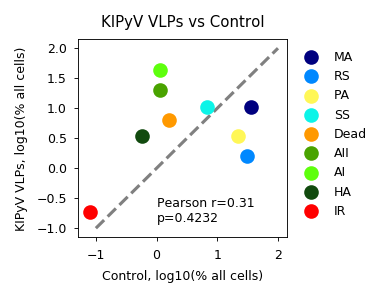

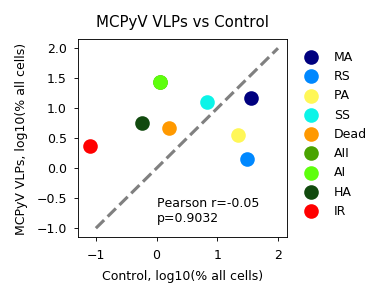

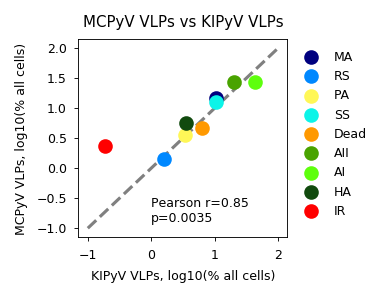

In [78]:
pseudopct = 0.0
logcell_fracs = np.log10(cell_fracs+pseudopct)

color = [cdd['population'][i] for i in cell_fracs.index]
for comb in combs:
    xlab = comb[0]
    ylab = comb[1]
    
    x = logcell_fracs[xlab]
    y = logcell_fracs[ylab]
    
    #botlim = min(min(x),min(y))
    botlim = -1
    
    a,fig,gs = rz.startfig(6.5,5)
    a.plot((botlim,2),(botlim,2),
           '--',color='0.5',zorder=-1)
    
    for i,j,pop,c in zip(x,y,cell_fracs.index,color):
        a.scatter(i,j,color=c,label=pop)
        
    a.set_xlabel(xlab+", log10(% all cells)")
    a.set_ylabel(ylab+", log10(% all cells)")
    a.legend(bbox_to_anchor=(1,1))
    
    title = "%s vs %s"%(ylab,xlab)
    a.set_title(title)
    
    (r,p) = scipy.stats.pearsonr(x,y)
    
    a.text(np.log10(1),-0.9,"Pearson r=%.2f\np=%.4f"%(r,p))

    gs.tight_layout(fig)
    plt.savefig("postannotoutputs/%s_log.pdf"%title)
    plt.show()